Imports

In [69]:
from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody, PowerLaw1D
from astropy.io import fits

import numpy as np

import matplotlib.pyplot as plt

from utils.frd import elex_transfcnl
from utils.fsl import calc_responsivity, produce_spectra, read_coadd

import h5py

Original inteferogram

Time: 41585542646180000
MTM length: 0
MTM speed: 0


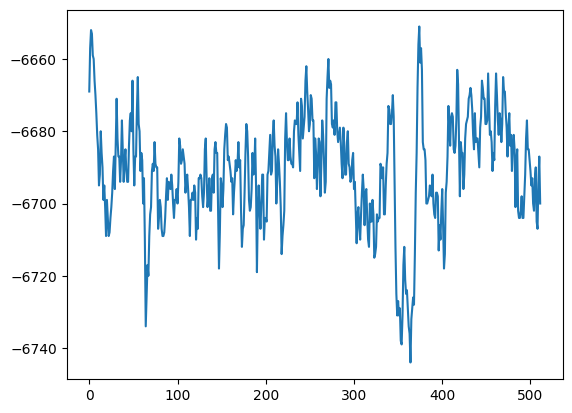

In [70]:
erecno = 170
ifg_ind = 550_000  # this is a pretty good one
# ifg_ind = 55_000

data_orig = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5"
    )
data_ll = data_orig["fdq_sdf_ll"]
original_ifg = data_ll["ifg_data/ifg"][ifg_ind]

# what is this time
t0 = data_ll["ct_head/time"][ifg_ind]

eng_time = data_ll["dq_data/eng_time"][ifg_ind]
print(f"Time: {eng_time}")

mtm_length = data_ll['sci_head/mtm_length'][ifg_ind]
print(f"MTM length: {mtm_length}")
mtm_speed = data_ll['sci_head/mtm_speed'][ifg_ind]
print(f"MTM speed: {mtm_speed}")

plt.plot(original_ifg)
plt.show()

In [71]:
data_orig_eng = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5"
    )

eng_id = -1
# print(len(str(t0)))

arr = list(data_orig_eng["ct_head/time"])

while eng_id < 0:
    try:
        # eng_id = arr.index(t0)
        eng_id = arr.index(str(eng_time))
    except ValueError:
        # t0 = str(t0)[:-1]
        eng_time = str(eng_time)[:-1]
        # print(t0)
        # print(eng_time)
        # arr = [str(elem)[:len(t0)] for elem in arr]
        arr = [str(elem)[:len(eng_time)] for elem in arr]

# print(eng_id)

xmit_mtm_len = data_orig_eng["chan/xmit_mtm_len"][eng_id]
print(f"Xmit MTM length: {xmit_mtm_len}")
xmit_mtm_speed = data_orig_eng["chan/xmit_mtm_speed"][eng_id]
print(f"Xmit MTM speed: {xmit_mtm_speed}")

Xmit MTM length: [0 0 0 0]
Xmit MTM speed: [0 0 0 0]


Range definition

In [72]:
# dGHz = 17 * u.GHz  # Taken from Explanatory Supplement, page 14 for LRES
# dGHz = 4.2 * u.GHz  # Taken from Explanatory Supplement, page 14 for hres
dGHz = 13.604162 * u.GHz
f_GHz = np.arange(0, 43) * dGHz + 68.020812
# f_GHz = np.arange(1, 513) * dGHz

dnu = dGHz.to("cm-1", equivalencies=u.spectral())
# dnu = 0.57 / u.cm
nu = np.arange(1, 513) * dnu

# dGHz = dnu.to("GHz", equivalencies=u.spectral())
# f_GHz = np.arange(1, 513) * dGHz

# x_max = dnu.to("cm", equivalencies=u.spectral())
x_max = 1.22 * u.cm
dx = x_max / 512
x = np.arange(1, 513) * dx

# dnu = 1 / x_max
# nu = np.arange(1, 513) * dnu
print(max(nu))

dGHz = dnu.to("GHz", equivalencies=u.spectral())
f_GHz = np.arange(1, 513) * dGHz

# x = np.arange(1, 513)

# nu = 1 / x
# nu_max = max(nu)
# nu = np.arange(1, 513) * nu_max / 512

# x0 = (max(x) + min(x)) / 2
x0 = x[360] # page 37 of the explanatory supplement for LLSS RLSS

Forcing the maximum value for cm$^{-1}$ to be 21

In [104]:
nu_min = 2 / u.cm
nu_max = 21 / u.cm
nu = np.linspace(nu_min, nu_max, 512)
dnu = nu[1] - nu[0]
print(dnu)

x_max = dnu.to("cm", equivalencies=u.spectral())
x = np.linspace(0, x_max, 512)
x0 = x[360]

dGHz = dnu.to("GHz", equivalencies=u.spectral())
f_GHz = np.linspace(1e-5, 1, 512) * dGHz

print(dGHz)

0.03718199608610551 1 / cm
1.1146881999999951 GHz


In [105]:
1/1.22

0.819672131147541

In [74]:
def transform_to_ifg(sky, bb_ical):
    sky = sky.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))
    bb_ical = bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))

    diff = sky - bb_ical

    ifg = np.zeros(len(x))

    for i in range(len(x)):
        ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu.value * (x[i].value - x0.value)))
        # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

    # ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

    return diff, ifg

Black body definitions

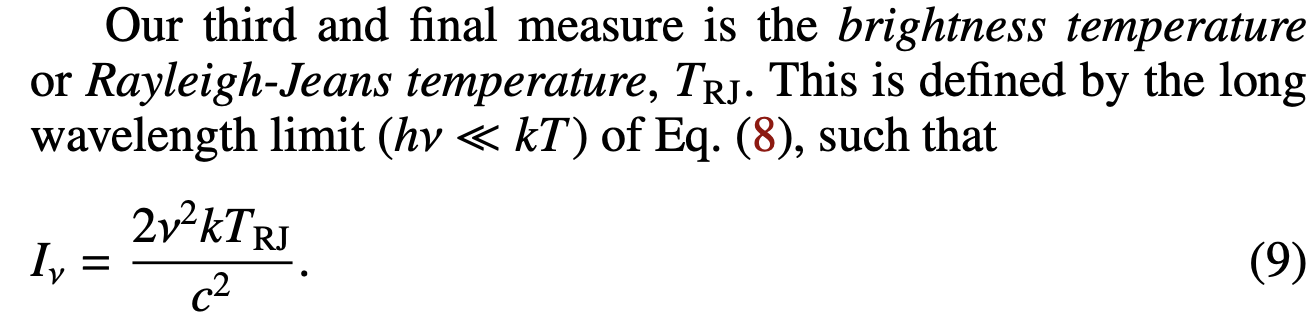
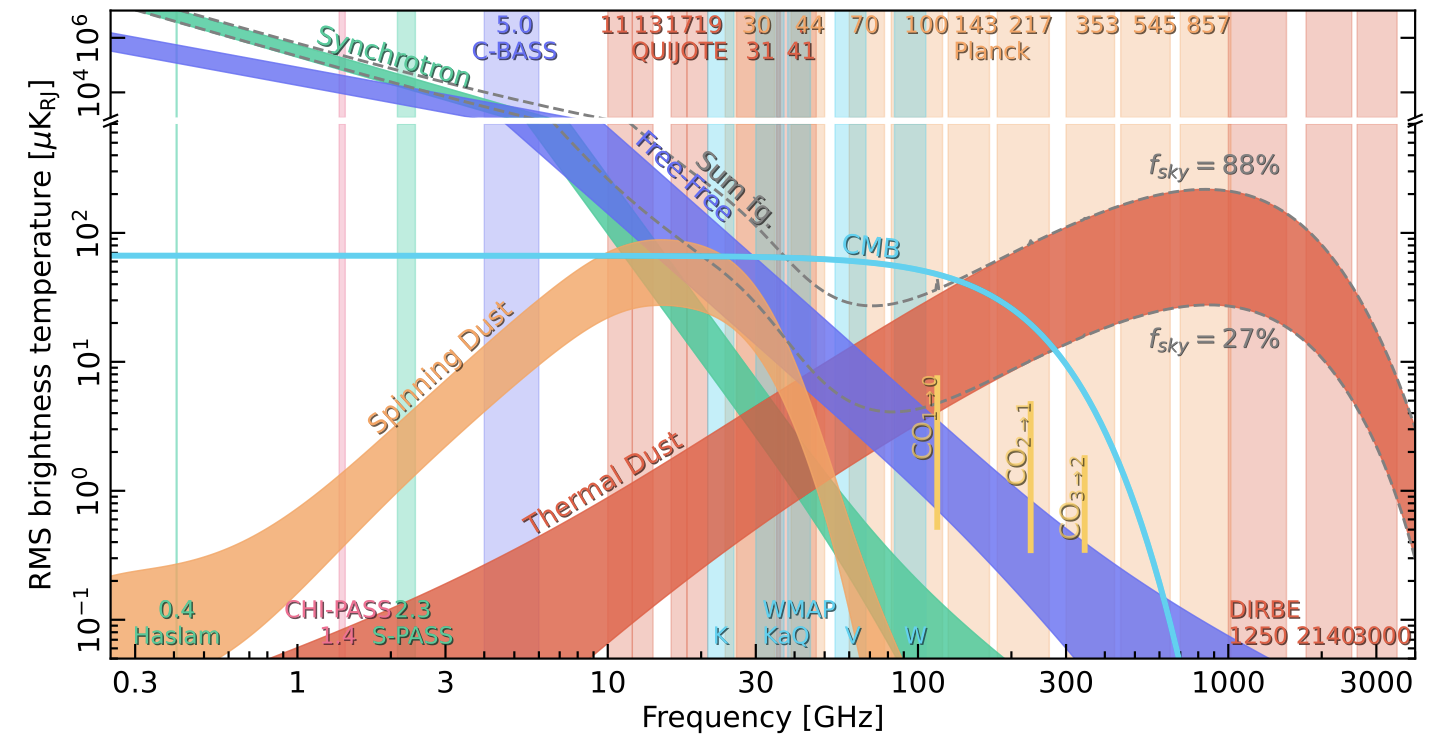
(BeyondPlanck I. Global Bayesian analysis of the Planck Low Frequency Instrument data)

In [75]:
t_cmb = 2.72548 * u.K  # Fixsen, 2009

bb_cmb = BlackBody(t_cmb)
bb_cmb = bb_cmb(f_GHz)
# bb_cmb = bb_cmb.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_cmb = bb_cmb.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

t_ical = (0.1 * data_orig_eng["en_analog/grt/a_hi_ical"][eng_id] + 0.9 * data_orig_eng["en_analog/grt/b_hi_ical"][eng_id]) * u.K

print(t_ical)

# bb_ical = BlackBody(2.76 * u.K)
bb_ical = BlackBody(t_ical)
bb_ical = 0.96 * bb_ical(f_GHz)
# bb_ical = bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_ical = bb_ical.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

[2.7514012] K


## Sky

Inteferogram

In [76]:
diff, ifg = transform_to_ifg(bb_cmb, bb_ical)
print(ifg)

[ 1.98387171e-20  1.52602932e-20  4.20243457e-21 -8.55253551e-21
 -1.75400975e-20 -1.89531449e-20 -1.22533678e-20 -3.72925040e-22
  1.15675287e-20  1.84645298e-20  1.74117232e-20  8.92344361e-21
 -3.31268937e-21 -1.40366337e-20 -1.86757929e-20 -1.52935460e-20
 -5.39660923e-21  6.73489308e-21  1.58973258e-20  1.81943590e-20
  1.26928625e-20  1.80057288e-21 -9.78670188e-21 -1.71084152e-20
 -1.70618088e-20 -9.71591115e-21  1.73909615e-21  1.23764300e-20
  1.76506596e-20  1.53390356e-20  6.47747705e-21 -5.10260249e-21
 -1.44299862e-20 -1.75267569e-20 -1.31039430e-20 -3.09727040e-21
  8.17933678e-21  1.58926386e-20  1.67607228e-20  1.04487033e-20
 -3.03774047e-22 -1.08709725e-20 -1.67302033e-20 -1.53966744e-20
 -7.47665485e-21  3.60717320e-21  1.30941638e-20  1.69296287e-20
  1.34970591e-20  4.29892740e-21 -6.70044549e-21 -1.47827728e-20
 -1.64989621e-20 -1.11403804e-20 -1.03089230e-21  9.48043613e-21
  1.58895665e-20  1.54667071e-20  8.41849056e-21 -2.21146210e-21
 -1.18563260e-20 -1.63873

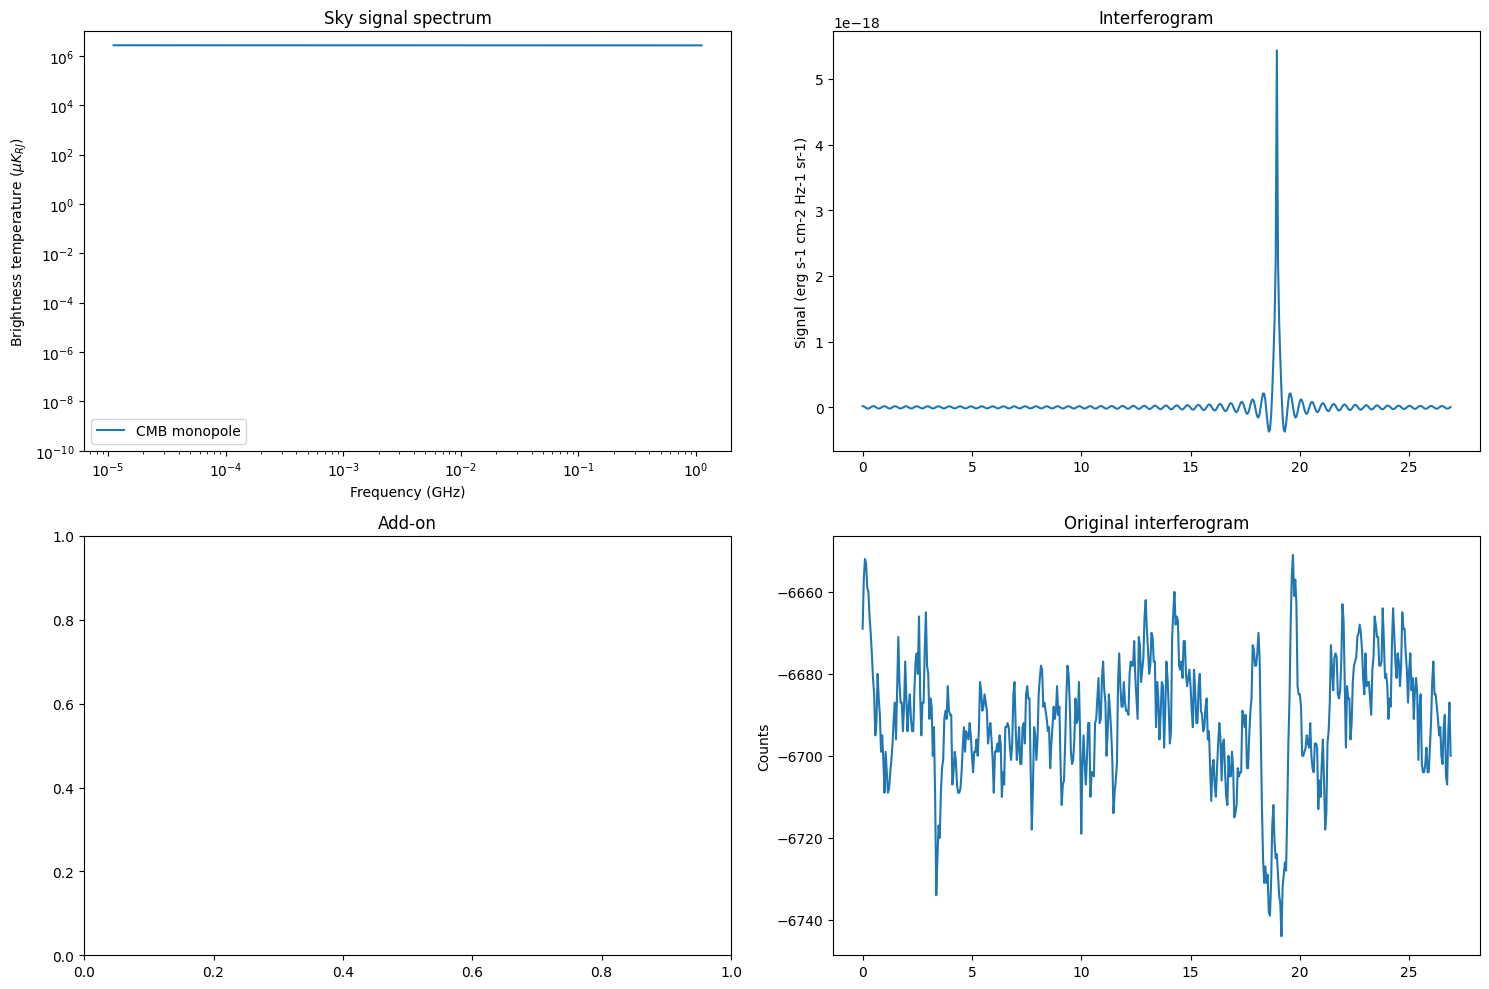

In [77]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_GHz, bb_cmb - t_cmb, label="CMB")
ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

CMB anisotropies

In [78]:
dt = 3.5 * u.mK

cmb_anisotropies = bb_cmb * np.exp(c.h * f_GHz / (c.k_B * t_cmb)) / (np.exp(c.h * f_GHz / (c.k_B * t_cmb)) - 1) * c.h * f_GHz / c.k_B / t_cmb ** 2 * dt
cmb_anisotropies = cmb_anisotropies.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

In [79]:
sky = bb_cmb + cmb_anisotropies

diff, ifg = transform_to_ifg(sky, bb_ical)

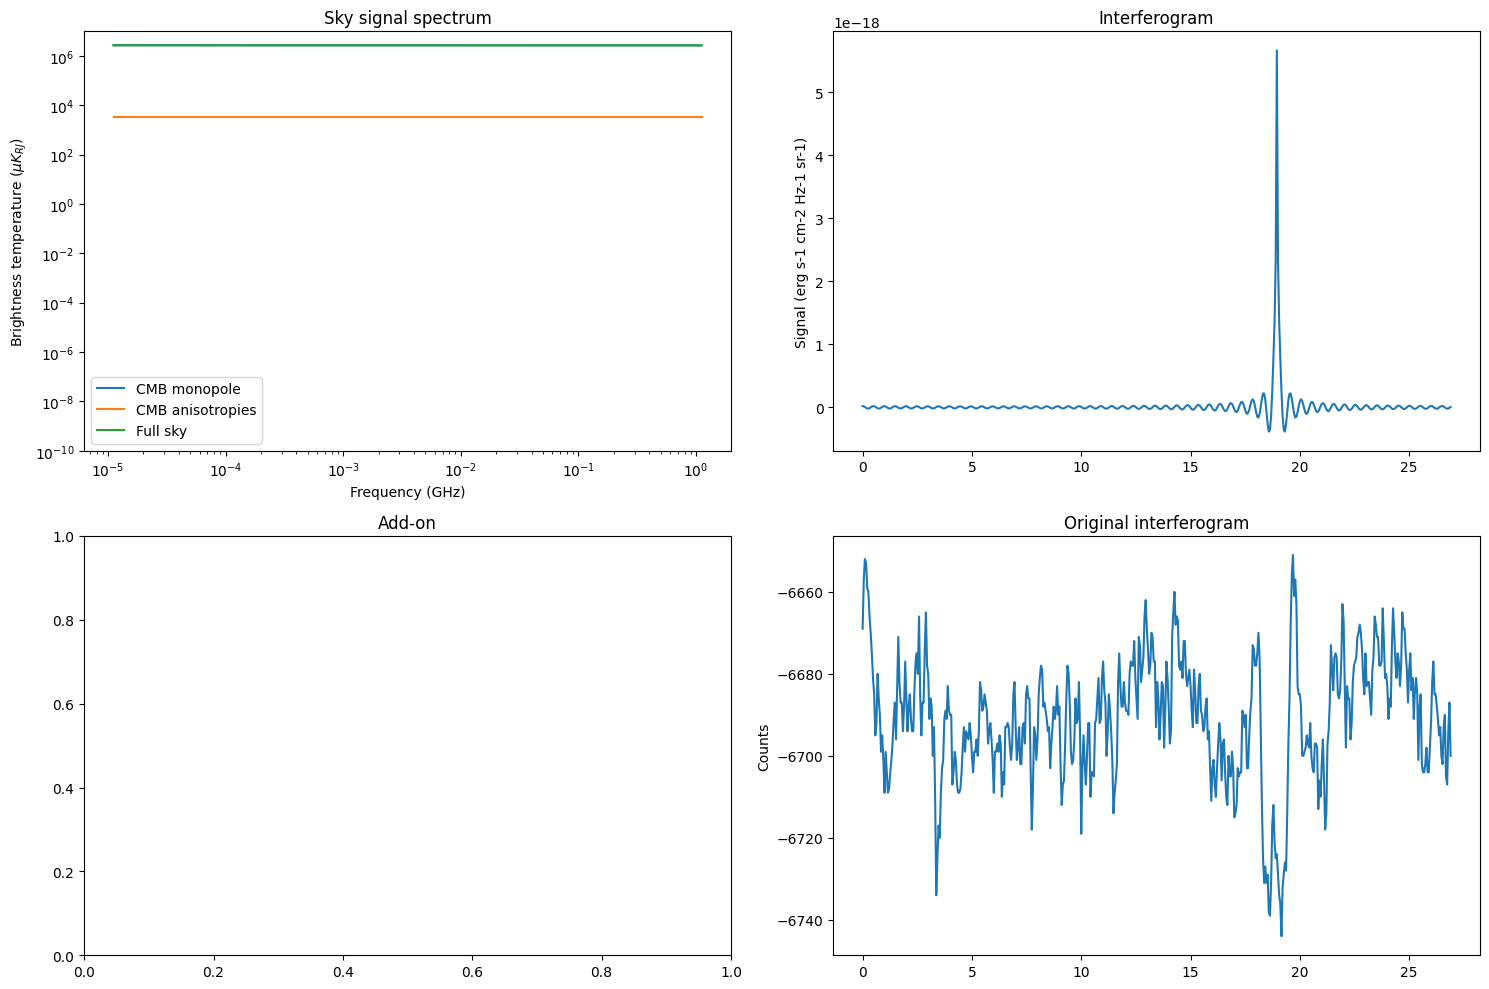

In [80]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, sky, label="Full sky")
# ax[0,0].plot(f_GHz, bb_cmb - t_cmb, label="CMB")
ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Synchrotron radiation

In [81]:
# beta_synch = -3.07 
# nu0_synch = 408 * u.MHz

# # S_v0 = 1.0 * u.erg / u.s / u.cm**2 / u.Hz / u.sr
# amplitude_synch = 30 * u.K

# synchrotron = amplitude_synch * (f_GHz / nu0_synch)**beta_synch
# synchrotron = synchrotron.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))
# # synchrotron = synchrotron.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))

In [82]:
# sky = bb_cmb + cmb_anisotropies + synchrotron

# _, ifg = transform_to_ifg(sky, bb_ical)

In [83]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
# ax[0,0].plot(f_GHz, sky, label="Total sky signal")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_ylim(1e-10,1e7)
# ax[0,0].set_yscale("log")
# ax[0,0].set_xscale("log")
# ax[0,0].legend()

# ax[1,0].set_title("Add-on")

# ax[0,1].plot(x, ifg)
# # ax[1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Interferogram")
# # ax[0,1].set_ylim(-2e-14,5e-14)

# ax[1,1].plot(x, original_ifg)
# # ax[2].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

Thermal dust

In [84]:
# Planck 2013 results. XI. All-sky model of thermal dust emission
# nu0_dust = 353 * u.GHz
nu0_dust = 1800 * u.GHz
beta_dust = 1.62
t_dust = 19.7 * u.K
optical_depth_nu0 = 9.6 * 10**(-7)

dust_bb = BlackBody(t_dust)
dust = optical_depth_nu0 * dust_bb(f_GHz) * (f_GHz / nu0_dust)**beta_dust
# dust = dust.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))
dust = dust.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

In [85]:
sky = bb_cmb + cmb_anisotropies + dust #+ synchrotron

diff, ifg = transform_to_ifg(sky, bb_ical)
save_ifg = ifg

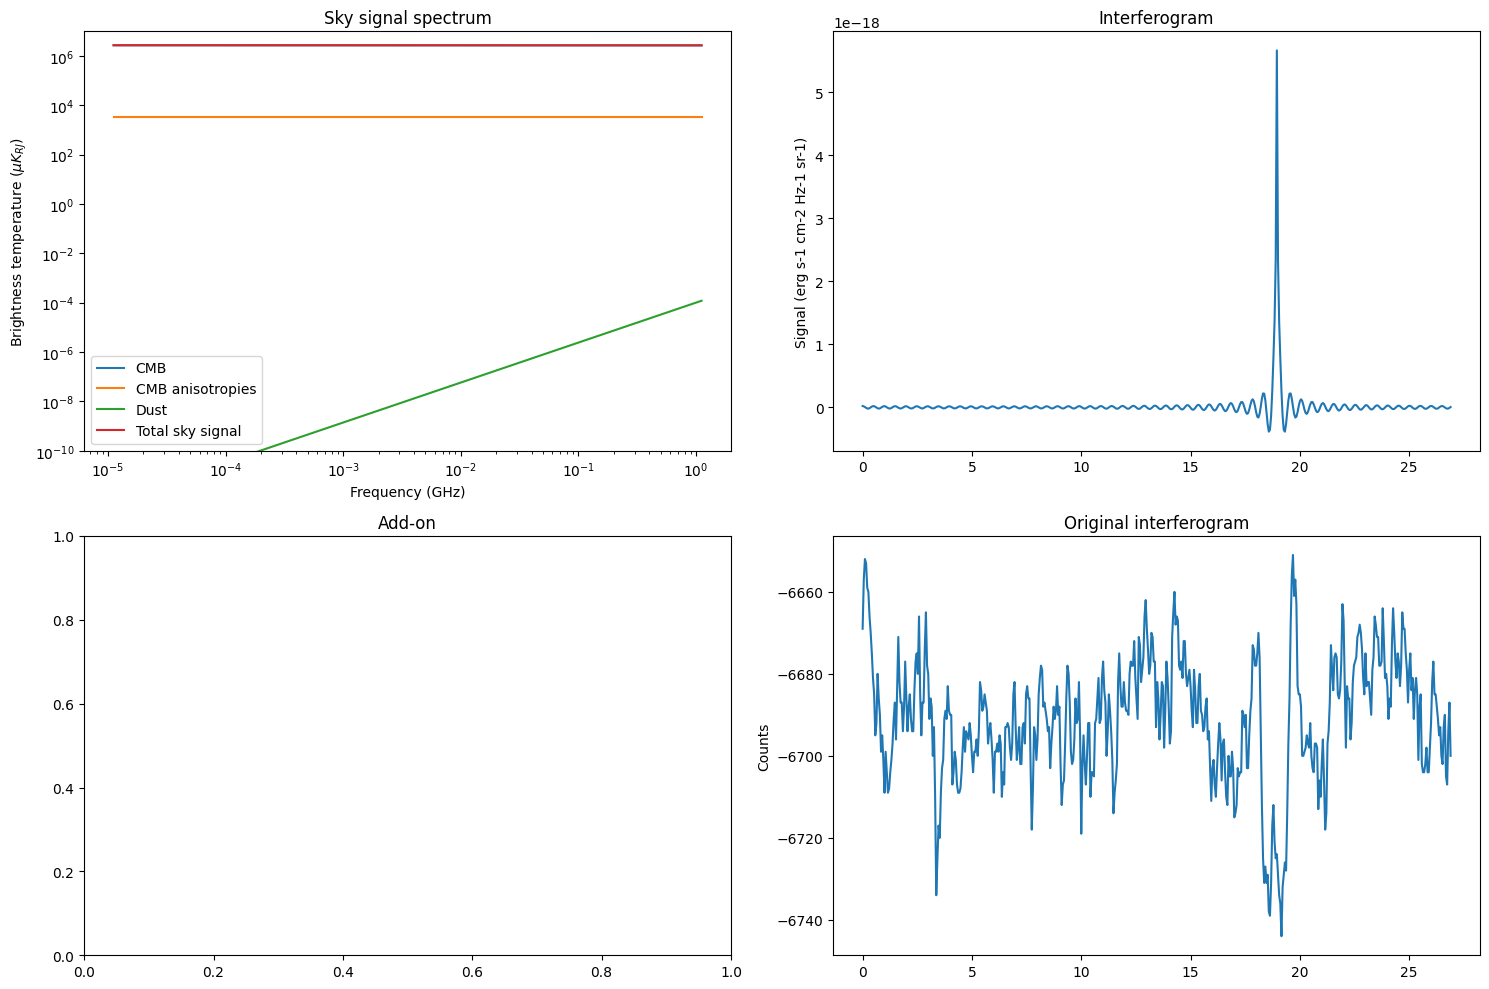

In [86]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)

# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Add lines?

## Instrument effects

Dealing with fits file

In [87]:
data_lowf = fits.open('FIRAS_CALIBRATION_MODEL_LLSS.FITS')
data_high = fits.open('FIRAS_CALIBRATION_MODEL_LHSS.FITS')

In [106]:
len(data_lowf)
data_lowf[0].header
# data_lowf[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '24/09/97'           / FITS file creation date (dd/mm/yy)             
ORIGIN  = 'CDAC    '           /  Cosmology Data Analysis Center                
TELESCOP= 'COBE    '           /  COsmic Background Explorer satellite          
INSTRUME= 'FIRAS   '           /  COBE instrument [DIRBE, DMR, FIRAS]           
OBJECT  = 'ALL-SKY '        

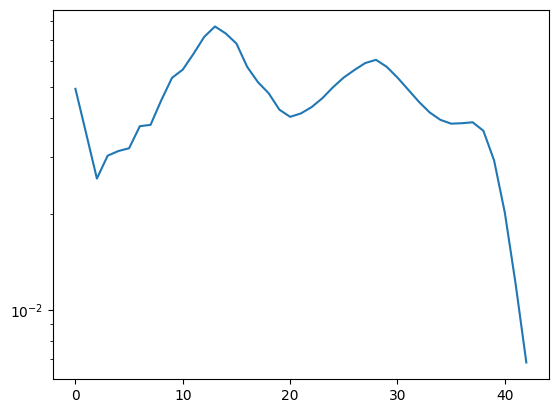

In [89]:
otf_real_lowf = data_lowf[1].data["RTRANSFE"][0]
otf_im_lowf = data_lowf[1].data["ITRANSFE"][0]
otf_lowf = np.sqrt(otf_real_lowf**2 + otf_im_lowf**2)

otf = otf_lowf[otf_lowf > 0]

plt.plot(otf)
plt.yscale("log")
plt.show()

In [90]:
# otf_real_high = data_high[1].data["RTRANSFE"][0]
# otf_im_high = data_high[1].data["ITRANSFE"][0]
# otf_high = np.sqrt(otf_real_high**2 + otf_im_high**2)

# plt.plot(otf_high)
# plt.yscale("log")
# plt.show()

In [91]:
# otf_total = otf_lowf + otf_high

# plt.plot(nu[:len(otf_total)],otf_total)
# plt.yscale("log")

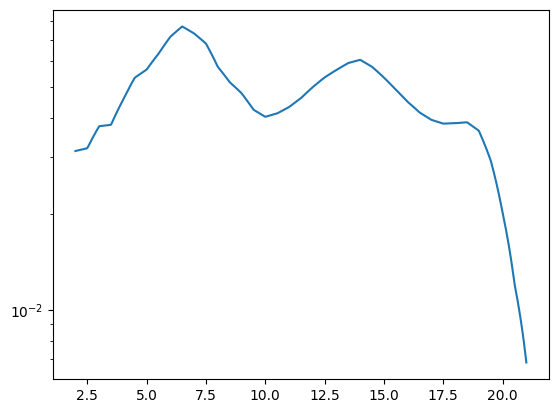

In [92]:
otf = np.interp(nu, np.linspace(0, max(nu), len(otf)), otf)

plt.plot(nu, otf)
plt.yscale("log")
plt.show()

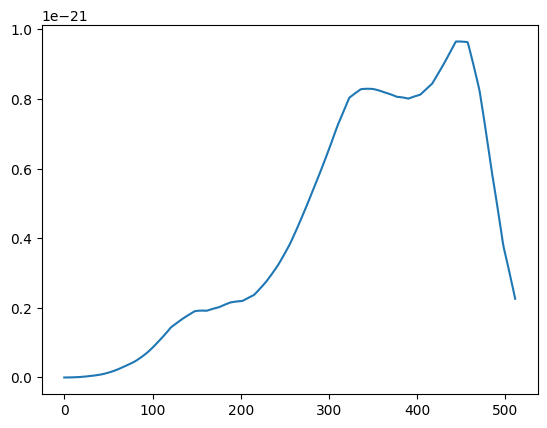

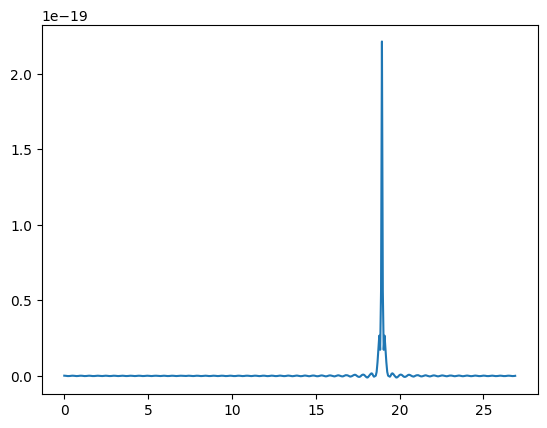

In [93]:
diff = diff * otf

plt.plot(diff)
plt.show()
ifg = np.zeros(len(x))

for i in range(len(x)):
    # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu.value * (x[i] - x0).value))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

plt.plot(x, ifg)

Adding ETF

In [94]:
# Got the samprate directly from the file /mn/stornext/d5/data/duncanwa/FIRAS/firas_analysis_original/firas_pipeline/reference/fex_samprate.txt
etf = elex_transfcnl(samprate=681.43, nfreq=512)

# etf = etf[np.random.randint(0, len(etf))]
etf = etf[erecno]

print(diff)

# We multiply the spectrum of the radiation sources by the ETF, as described in page 461 of Fixsen 1993
diff = diff / etf

# print(diff)

ifg = np.zeros(len(x))

for i in range(len(x)):
    # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu.value * (x[i] - x0).value))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)


[1.05101553e-31 4.07217942e-27 1.62299115e-26 3.65089684e-26
 6.49450138e-26 1.01573708e-25 1.46430708e-25 1.99551667e-25
 2.60972235e-25 3.30728059e-25 4.08854781e-25 4.95388041e-25
 5.90363475e-25 6.93816717e-25 8.10831041e-25 9.42577719e-25
 1.08584799e-24 1.24095665e-24 1.40821846e-24 1.58794814e-24
 1.78046041e-24 1.98606993e-24 2.20509134e-24 2.43783925e-24
 2.68462825e-24 2.94577288e-24 3.22158766e-24 3.50862239e-24
 3.77597556e-24 4.05334235e-24 4.34074333e-24 4.63819908e-24
 4.94573017e-24 5.26335717e-24 5.59110064e-24 5.92898115e-24
 6.27701926e-24 6.63523553e-24 7.00365052e-24 7.38228479e-24
 7.77115888e-24 8.24410429e-24 8.77489049e-24 9.32740422e-24
 9.90206554e-24 1.04992944e-23 1.11195109e-23 1.17631349e-23
 1.24305862e-23 1.31222848e-23 1.38386503e-23 1.45801027e-23
 1.53470616e-23 1.61399467e-23 1.69624567e-23 1.78247329e-23
 1.87153812e-23 1.96348532e-23 2.05836001e-23 2.15620735e-23
 2.25707246e-23 2.36100048e-23 2.46803654e-23 2.57822575e-23
 2.69161324e-23 2.808244

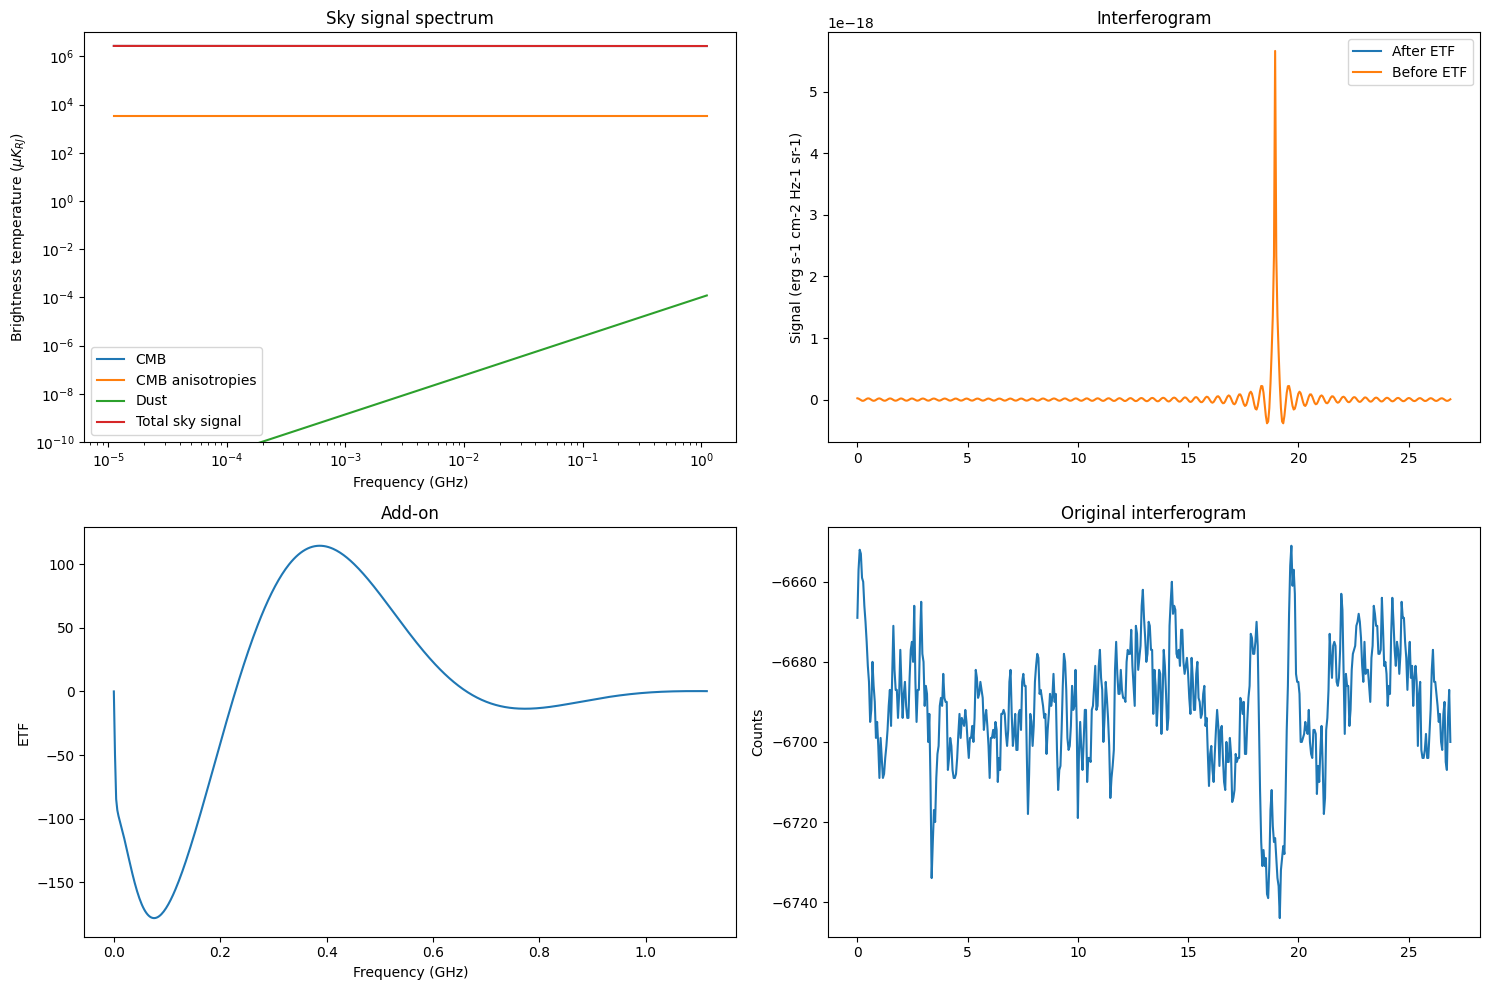

In [95]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_GHz, etf)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("ETF")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x[2:], ifg[2:], label="After ETF")
ax[0,1].plot(x, save_ifg, label="Before ETF")
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)
ax[0,1].legend()

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Bolometer model

In [96]:
# S0 = 1e9 * u.A
# omega = 2 * np.pi * f_GHz
# tau = 1e-3 * u.s

# bolometer = S0 / (1 + 1j * omega * tau)

In [97]:
# coadd_recs = read_coadd(args.fil_path, args.channel, args.scan_mode, config, input_type=args.input, quality=quality)
# vspec_rec  = produce_spectra(coadd_recs[j], chan, scan_mode, apodl_all, etfl_all) 
# bol_volt = vspec_rec['coad_spec_data']['bol_volt']

# tbol, qrad, S0, tau = calc_responsivity(bol_volt, cmd_bias, tdet, model['bolparm'])

In [98]:
bol_volt = data_orig_eng["en_analog/group1/bol_volt"][eng_id, 3]
Tbol = (data_orig_eng["en_analog/grt/a_lo_bol_assem"][eng_id, 3] + data_orig_eng["en_analog/grt/b_lo_bol_assem"][eng_id, 3]) / 2
cmd_bias = data_orig_eng["en_stat/bol_cmd_bias"][eng_id, 3]

In [99]:
rscale = 1.0e-7 

# RL = 4.0e7 
RL = 40e6 # Calibration of the COBE FIRAS instrument (Fixsen et al. 1994) - 40 MOhm

# set by me
Jo = 0
Jg = 1.0

V = (bol_volt - Jo) / Jg

G1 = 1.0e-8
beta = 1
G = G1*Tbol**beta
rho = 1

X = V*rho

H = Tbol / X * np.tanh(X/Tbol)

T0 = 100.0

DT = 1.0/H - 1.0 - 0.5*np.sqrt(T0/Tbol)

R = RL*V / (cmd_bias - V)
Z = (G*Tbol*R + DT*V**2) / (G*Tbol*R/H - DT*V**2)

S0 = rscale * R * (Z-H) / (V * (Z*R/RL + 1.0) * (H + 1.0))

In [100]:
C3 = 1.0e-10
C1 = 1.0e-10

C = C3*Tbol**3 + C1*Tbol

tau = C/G * (Z+1.0) * (R*H + RL) / ((Z*R + RL) * (H + 1.0))

In [101]:
omega = 2 * np.pi * f_GHz

bolometer = S0 / (1 + 1j * omega.value * tau)

In [102]:
diff = diff / bolometer

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

UnitTypeError: Can only apply 'cos' function to quantities with angle units

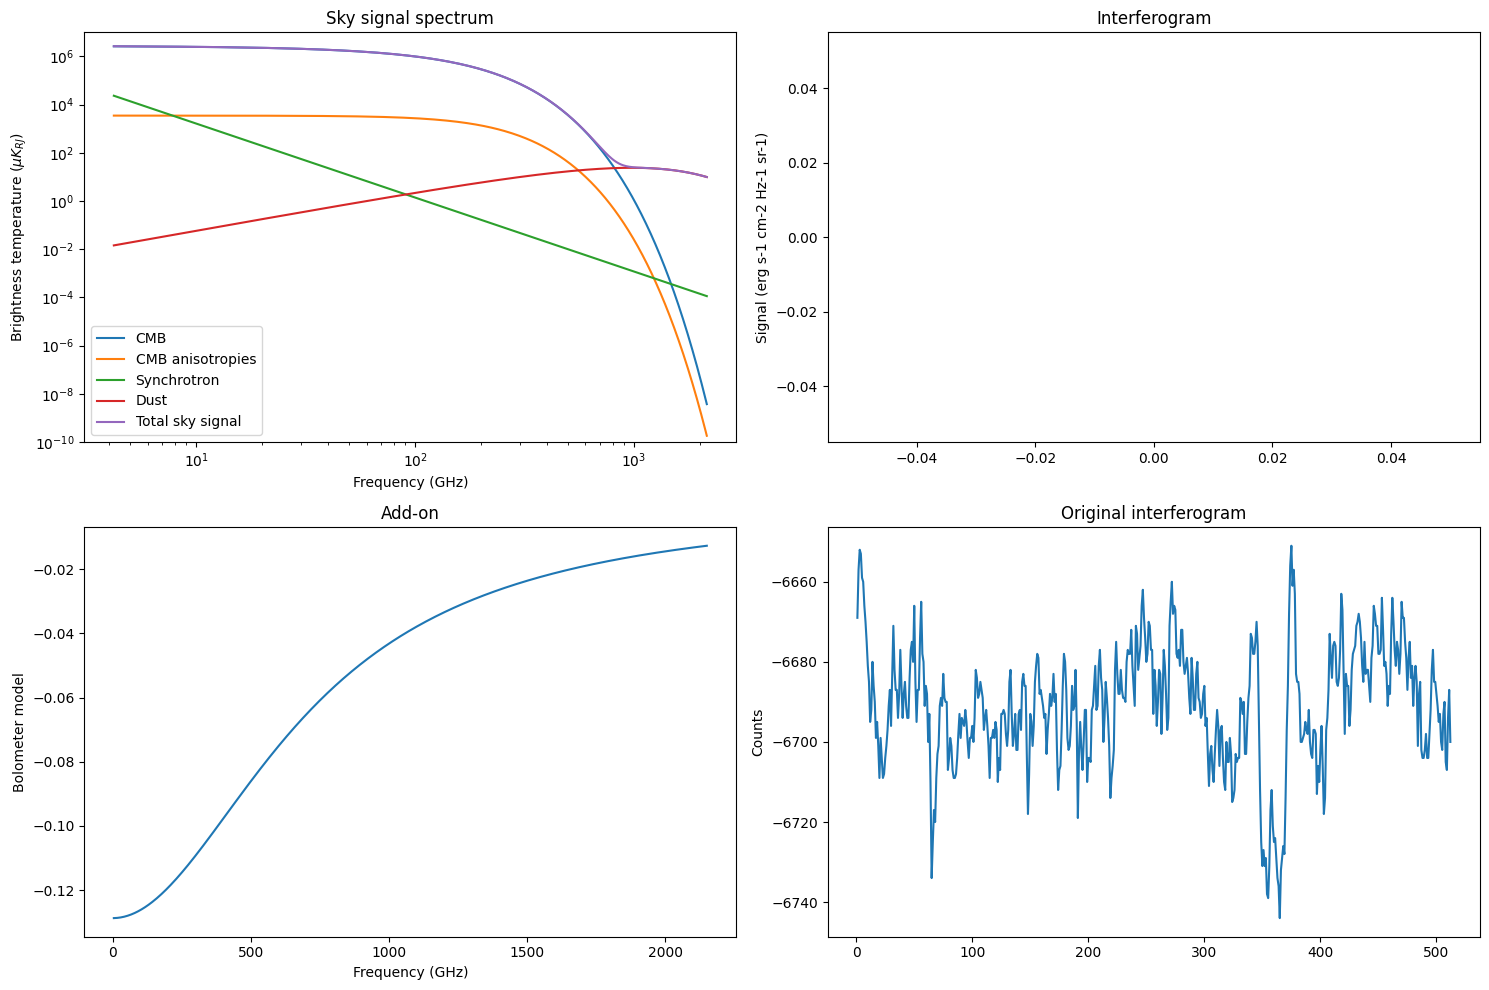

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_GHz, bolometer)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Bolometer model")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

1/f noise

In [ ]:
kmin = 0
kmax = 512

ck = [0]
cnk = []
for k in range(1, kmax):
    fk = (k * len(x) / (2*np.pi))
    phase = np.random.uniform(0, 2*np.pi)
    ck.append(1/np.abs(fk) * np.cos(phase) * 1e-12)

diff = diff.value + ck

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

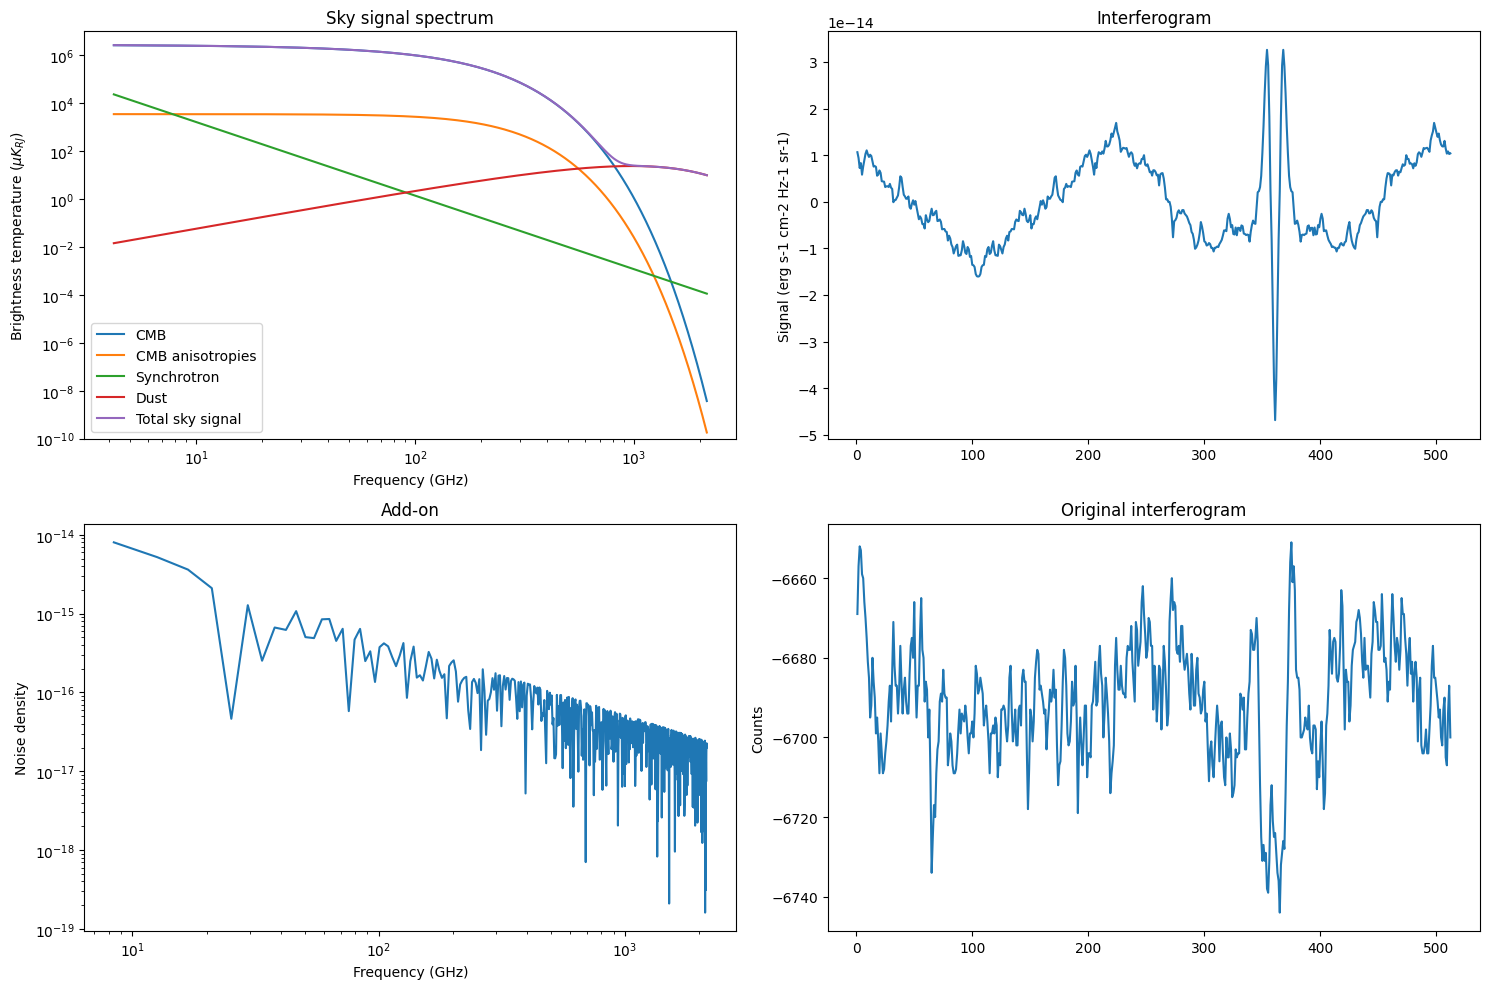

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

# ax[1,0].plot(x, noise1f)
ax[1,0].plot(f_GHz[1:], np.abs(ck[1:]))
ax[1,0].set_title("Add-on")
ax[1,0].set_xscale("log")
ax[1,0].set_yscale("log")
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Noise density")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Adding white noise

In [ ]:
# estimation for level of white noise
max_signal = 50
max_noise = 5

noise_level = max(abs(ifg)).value * max_noise / max_signal

noise = np.random.normal(0, noise_level, len(x)) * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

ifg = ifg + noise

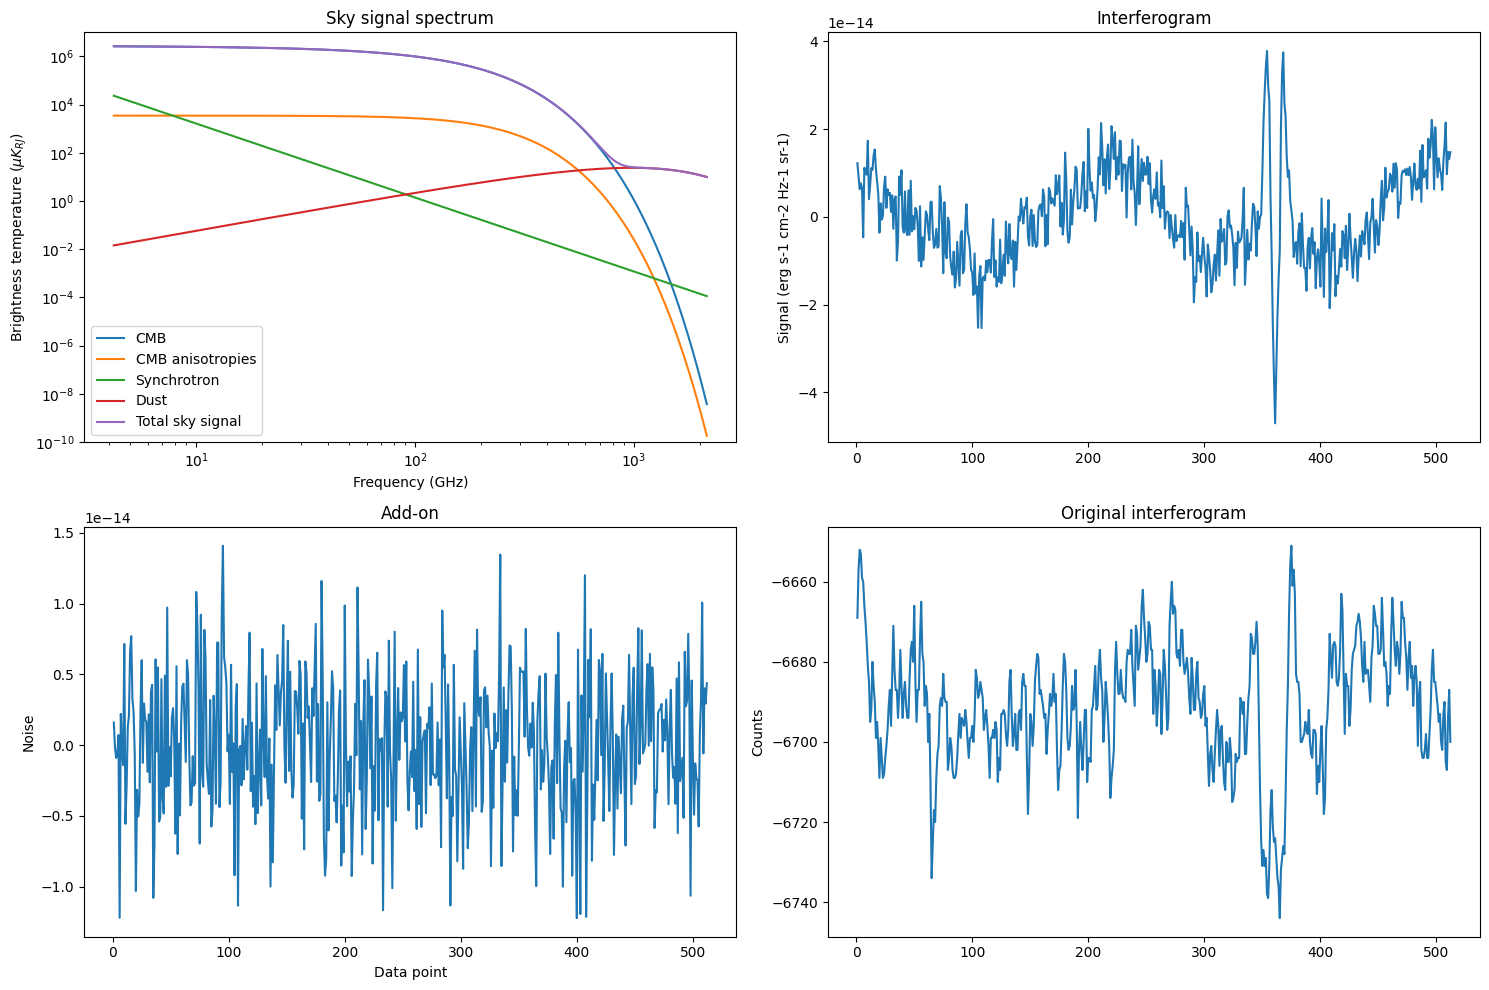

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, noise)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Noise")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Defocusing correction

In [ ]:
# # add fourth order polynomial trend
# a = 1e-30
# b = 1e-30
# c = 1e-30
# d = 1e-30
# e = 1e-30

# # defocusing_correction = a + b * (x-x0) + c * (x-x0)**2 + d * (x-x0)**3 + e * (x-x0)**4
# defocusing_correction = np.cos(2 * np.pi * x / 250) * 5e-13

# ifg = ifg + defocusing_correction * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

In [ ]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
# ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
# ax[0,0].plot(f_GHz, dust, label="Dust")
# ax[0,0].plot(f_GHz, sky, label="Total sky signal")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")
# ax[0,0].set_ylim(1e-10,1e7)
# ax[0,0].legend()

# ax[1,0].plot(x, defocusing_correction)
# # ax[1,0].set_xlabel("Optical path (cm)")
# ax[1,0].set_title("Defocusing correction")
# ax[1,0].set_xlabel("Data point")

# ax[0,1].plot(x, ifg)
# # ax[1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

# ax[1,1].plot(x, original_ifg)
# # ax[2].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

Adding cosmic ray glitches

In [ ]:
n_glitches = 10
x_glitches = np.random.randint(0, len(x), n_glitches)

max_glitch = 10
glitch_level = max(abs(ifg)).value * max_glitch / max_signal

glitches = np.random.normal(0, glitch_level, n_glitches) 
glitch_curve = np.zeros(len(x))

for i, j in zip(x_glitches, range(len(glitches))):
    ifg[i] = ifg[i] + glitches[j] * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)
    glitch_curve[i] = glitches[j]


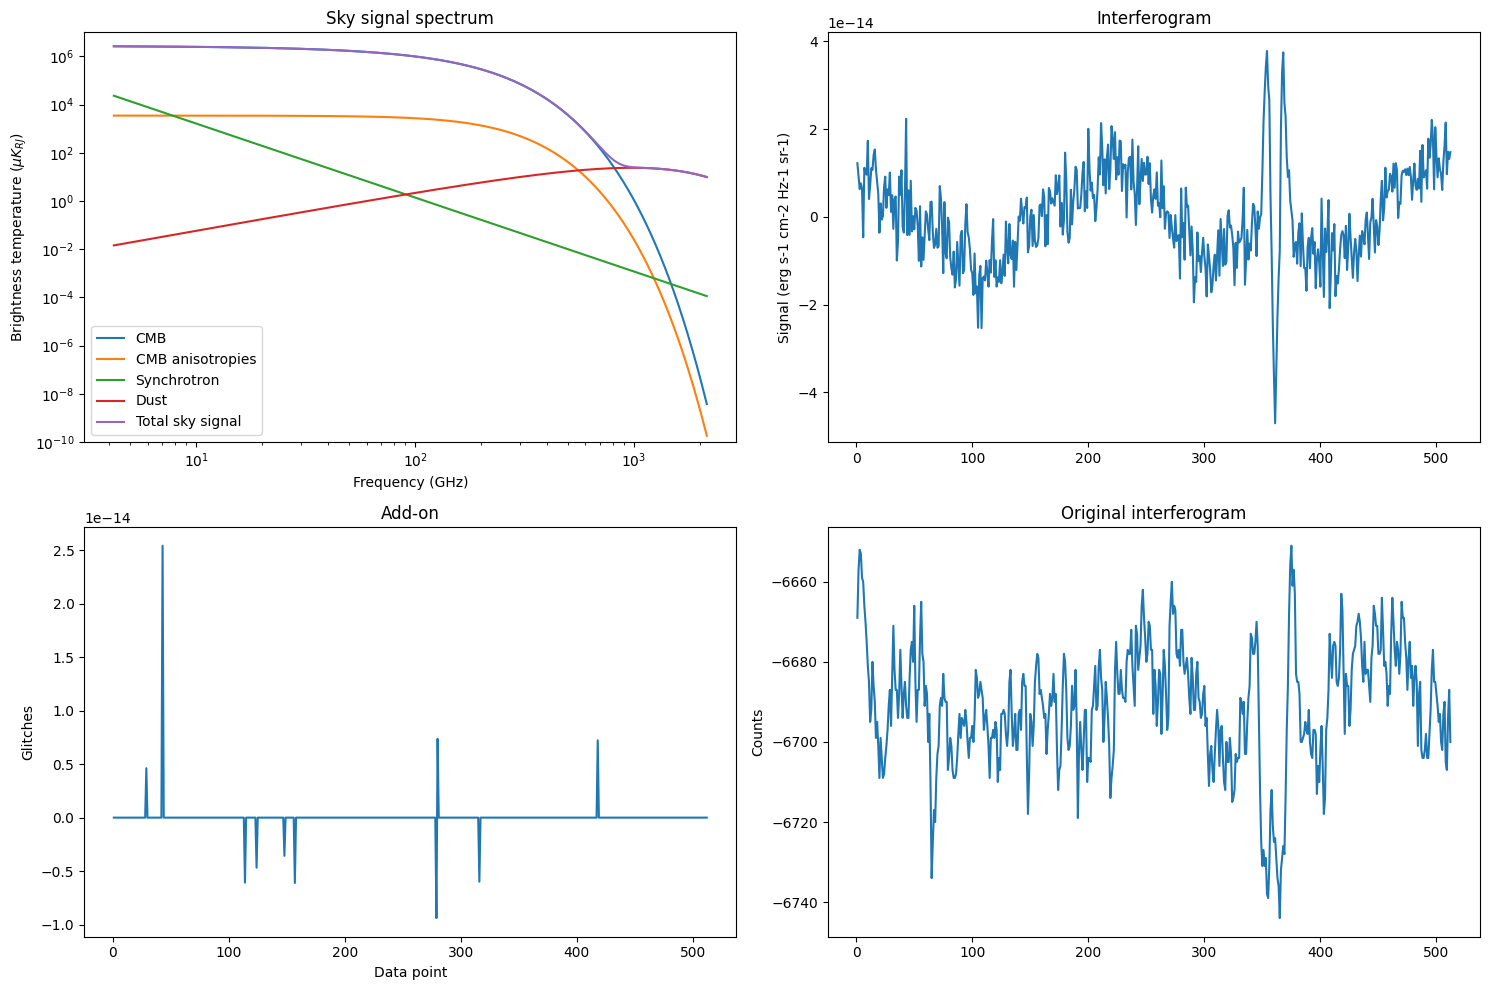

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, glitch_curve)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Glitches")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()